In [8]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path

# Global settings for matplotlib
fontsize = 8
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    #"font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})
print(Path.cwd())
DATA_SOURCE = Path.cwd() / ".." / 'data' / 'input' / 'raw'
PROC_SOURCE = Path.cwd() / ".." / 'data' / 'input' / "processed"
print( DATA_SOURCE.parent)
def get_bh_integral(df):
    b, h = df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), df.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
    h += 100
    return df.freq * 0.5*np.abs(np.sum(b * (np.roll(h, 1, axis=1) - np.roll(h, -1, axis=1)) , axis=1))  # shoelace formula

c:\Users\tpiepe\Repositories\magnet-challenge-2023\src
c:\Users\tpiepe\Repositories\magnet-challenge-2023\src\..\data\input


In [9]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
# full_b, full_h = ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), ds.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
# print(full_b.shape)

In [ ]:
# Display all available materials
materials = ds.loc[:, ["material"]]["material"].unique()
print(f"Materials: {materials}")

# Display all available temperatures
temperatures = ds.loc[:, ["temp"]]["temp"].unique()
print(f"Temperatures: {temperatures}")

Materials: ['3C90' '3C94' '3E6' '3F4' '77' '78' 'N27' 'N30' 'N49' 'N87']
Temperatures: [25 50 70 90]


In [ ]:
# Choose a temperature - material pair
temperature = 25
material = 'N49'

# Display all available frequencies for the temperature - material pair
frequencies = sorted(list(ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)]["freq"].unique()))
print(f"Frequencies: {frequencies}")

# downsampling with factor of ... (4 to get 1024 to 256 samples)
downsampling = 1

# filter data for the temperature - material pair
wp_ploss = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)]["ploss"].to_numpy()
wp_b_max = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)][[f"B_t_{k}" for k in range(0,1024, downsampling)]].to_numpy().max(1)
wp_b_vecs = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)][[f"B_t_{k}" for k in range(0,1024, downsampling)]].to_numpy()
wp_h_vecs = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)][[f"H_t_{k}" for k in range(0,1024, downsampling)]].to_numpy()
wp_freq = ds.loc[(ds["material"] == material) & (ds["temp"] == temperature)]["freq"].to_numpy()

# will be used later
no_samples = wp_b_vecs.shape[1]

Frequencies: [49950.0, 49960.0, 49970.0, 49980.0, 49989.9999999999, 50000.0, 50009.9999999999, 50020.0, 50040.0, 50049.9999999999, 50059.9999999999, 50069.9999999999, 50080.0, 50090.0, 50099.9999999999, 50129.9999999999, 50140.0000000001, 50150.0000000001, 50159.9999999999, 63010.0000000002, 63019.9999999998, 63030.0000000001, 63040.0000000002, 63060.0000000001, 63080.0000000001, 63090.0, 63100.0, 63110.0, 63120.0000000001, 63130.0000000002, 63140.0, 63150.0000000002, 63160.0000000001, 63170.0, 63180.0, 63190.0, 63209.9999999999, 63220.0000000001, 63229.9999999999, 79410.0000000002, 79420.0000000003, 79430.0000000002, 79439.9999999997, 79449.9999999997, 79460.0000000002, 79469.9999999999, 79480.0000000003, 79489.9999999998, 79500.0000000003, 79509.9999999997, 79519.9999999997, 79529.9999999999, 99900.0, 99910.0, 99920.0, 99930.0, 99940.0, 99950.0, 99960.0, 99970.0, 99980.0, 99990.0, 100000.0, 100010.0, 100020.0, 100030.0, 125850.0, 125860.0, 125880.0, 125890.0, 125900.0, 125910.0, 1259

1024
838
526
162
72
(2152, 1024)
(2152, 1024)


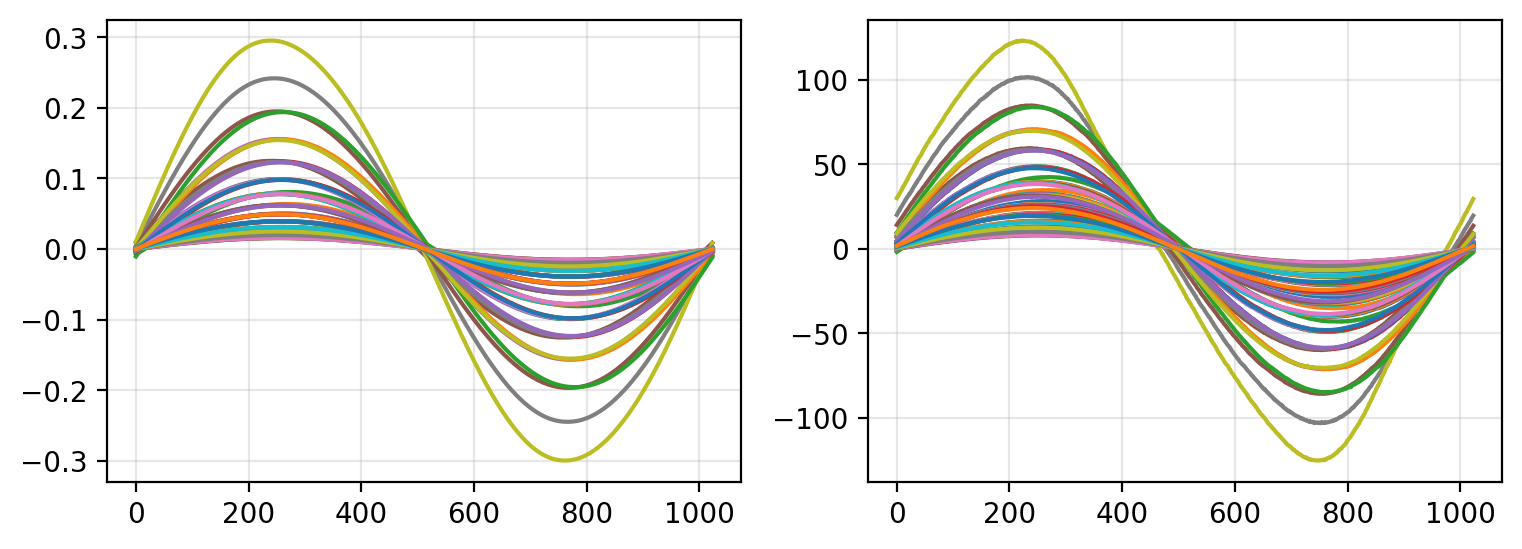

In [ ]:
fig, axes = plt.subplots(1, 2, dpi=200, figsize=(9, 3), sharex=True, sharey=False)


# Additional downsampling option
print(no_samples)
samples_per_periode = no_samples 
div_factor = int(no_samples / samples_per_periode)
b = wp_b_vecs[:, ::div_factor]
h = wp_h_vecs[:, ::div_factor]

# rms = np.sqrt(np.mean(b**2, axis=1)) 
# abs = np.mean(np.abs(b), axis=1)
# form_factors = rms / mean_abs
# print(rms)
# print(mean_abs)
# print(form_factors)

def form_factor(b): 
    """kf = rms / mean(abs)"""
    return np.sqrt(np.mean(b**2, axis=1))  / np.mean(np.abs(b), axis=1)

def crest_factor(b): 
    """ks = rms / max()"""
    return np.max(np.abs(b), axis=1)  / np.sqrt(np.mean(b**2, axis=1))

# filter with form factor: only keep sines
# form factor +/- interval
interval_kf = 0.005
desired_kf = np.pi/(2*np.sqrt(2))  # ideal sine

# filter with crest factor: only keep sines
# crest factor +/- interval
interval_kc = 0.005
desired_kc = np.sqrt(2)  # ideal sine

# initialize all True
filter_bool = [True] * b.shape[0]

# statements = [[crest_factor(b) < desired_kc * (1 + interval_kc)]]
statements = [list(form_factor(b) < desired_kf * (1 + interval_kf)),
              list(form_factor(b) > desired_kf * (1 - interval_kf)),
              list(crest_factor(b) < desired_kc * (1 + interval_kc)),
              list(crest_factor(b) > desired_kc * (1 - interval_kc))]

for statement in statements:
    filter_bool = [a and zr for a, zr in zip(filter_bool, statement)]
    print(np.array(filter_bool).sum())

b_sine = b[filter_bool]
h_sine = h[filter_bool]

b_max_sine = wp_b_max[filter_bool]
freq_sine = wp_freq[filter_bool]
ploss_sine = wp_ploss[filter_bool]

print(b.shape)
print(h.shape)
# print(b)
# print(h)
axes[0].plot(b_sine.T)
axes[1].plot(h_sine.T)

plt.show()

In [ ]:
def steinmetz(f, b, alpha, beta, k):
    return k*f**alpha*b**beta

def estimated_loss(alpha, beta, k, f_vec, b_vec):
    return steinmetz(f_vec, b_vec, alpha, beta, k)

def normalized_error(alpha, beta, k, f_vec, b_vec, p_loss_reference):
    return np.mean(abs((estimated_loss(alpha, beta, k, f_vec, b_vec) - p_loss_reference) / p_loss_reference))

In [ ]:
def loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = False):
    fig = plt.figure(figsize=(6, 8))
    ax = fig.add_subplot(projection='3d')

    
    z_label = "losses 10^x in W/m³" if log_plot else "losses in W/m³"

    # Estimation plot
    p1 = np.log10(p_estimated) if log_plot else p_estimated
    sc = ax.scatter(b_ax, f_ax, p1, color='red', label="estimated loss")
    z1=np.ones(shape=b_ax.shape)*min(p1)
    # lines
    for i,j,k,h in zip(b_ax, f_ax, p1, z1):
        ax.plot([i,i],[j,j],[k,h], color='grey')

    # Measurement plot
    p2 = np.log10(true_loss) if log_plot else true_loss
    sc = ax.scatter(b_ax, f_ax, p2, color='blue', label="measured loss")
    z2=np.ones(shape=b_ax.shape)*min(p2)
    # lines
    for i,j,k,h in zip(b_ax, f_ax, p2, z2):
        ax.plot([i,i],[j,j],[k,h], color='grey')


    sc = ax.scatter(b_ax, f_ax, np.log10(true_loss))
    ax.set_zlabel(z_label, fontsize=fontsize, rotation = 0)

    # sc = ax.scatter(b_max, freq, p_estimated)
    # sc = ax.scatter(b_max, freq, ploss)
    # plt.ylabel("frequency in Hz", fontsize=fontsize)
    plt.xlabel("Bpeak in T", fontsize=fontsize)
    plt.ylabel("frequency in Hz", fontsize=fontsize)
    plt.legend()


    plt.show()

In [ ]:
import optuna

def objective(trial):
    aa = trial.suggest_float('aa', 1, 2)
    bb = trial.suggest_float('bb', 2.5, 4)
    kk = trial.suggest_float('kk', 0.1, 100)
    return normalized_error(aa, bb, kk, freq_sine, b_max_sine, ploss_sine)

study = optuna.create_study()
study.optimize(objective, n_trials=500)

study.best_params  # E.g. {'x': 2.002108042}

[I 2023-06-29 08:31:32,202] A new study created in memory with name: no-name-c108190a-9ac9-40d4-aacf-f1a518f83a65
[I 2023-06-29 08:31:32,210] Trial 0 finished with value: 0.9936419548876216 and parameters: {'aa': 1.1457975839545238, 'bb': 3.8724193396175832, 'kk': 12.117898502961264}. Best is trial 0 with value: 0.9936419548876216.
[I 2023-06-29 08:31:32,213] Trial 1 finished with value: 0.8953222868330768 and parameters: {'aa': 1.2324938177329567, 'bb': 3.8702790246599283, 'kk': 68.96271256568183}. Best is trial 1 with value: 0.8953222868330768.
[I 2023-06-29 08:31:32,218] Trial 2 finished with value: 0.9603945399423593 and parameters: {'aa': 1.2047996514390271, 'bb': 3.9308870838993877, 'kk': 42.26917448669852}. Best is trial 1 with value: 0.8953222868330768.
[I 2023-06-29 08:31:32,222] Trial 3 finished with value: 0.8893506054284184 and parameters: {'aa': 1.0638543619096685, 'bb': 3.108943214509684, 'kk': 83.46087406081718}. Best is trial 3 with value: 0.8893506054284184.
[I 2023-06

[I 2023-06-29 08:31:32,257] Trial 10 finished with value: 19.116290357990383 and parameters: {'aa': 1.532391328469612, 'bb': 2.7565550533647922, 'kk': 17.17062523942181}. Best is trial 8 with value: 0.7799649907531131.
[I 2023-06-29 08:31:32,277] Trial 11 finished with value: 0.9682234241890204 and parameters: {'aa': 1.0025888533316223, 'bb': 3.1763837777497312, 'kk': 60.585539485480204}. Best is trial 8 with value: 0.7799649907531131.
[I 2023-06-29 08:31:32,299] Trial 12 finished with value: 1.5192125679047688 and parameters: {'aa': 1.3690681545700414, 'bb': 3.415237814435033, 'kk': 99.00175730173878}. Best is trial 8 with value: 0.7799649907531131.
[I 2023-06-29 08:31:32,314] Trial 13 finished with value: 0.9711356716616382 and parameters: {'aa': 1.0068835049742706, 'bb': 2.9593812540887114, 'kk': 29.268966432894644}. Best is trial 8 with value: 0.7799649907531131.
[I 2023-06-29 08:31:32,329] Trial 14 finished with value: 0.36212584802416664 and parameters: {'aa': 1.3676244538641245,

{'aa': 1.2722969182611774, 'bb': 2.888838147928334, 'kk': 31.13077836085693}

0.14955914534399778


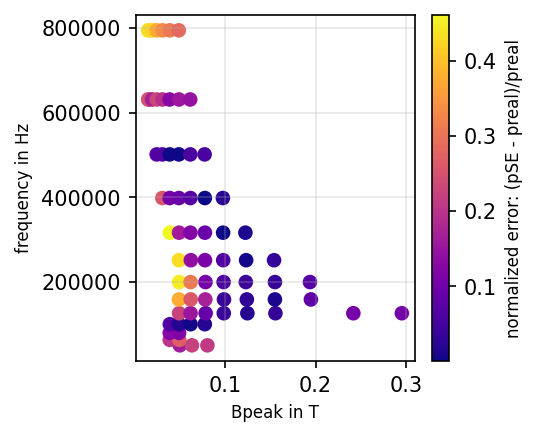

In [ ]:
# in sample error (training set = test set)
error_norm = (estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine) - ploss_sine) / ploss_sine

print(normalized_error(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine, ploss_sine))
# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)

# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = matplotlib.colormaps['plasma']
xy = range(20)
sc = plt.scatter(b_max_sine, freq_sine, c=abs(error_norm), vmin=None, vmax=None, s=None, cmap=cm)
cbar = plt.colorbar(sc, )
cbar.set_label('normalized error: (pSE - preal)/preal', fontsize=fontsize)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)

plt.show()

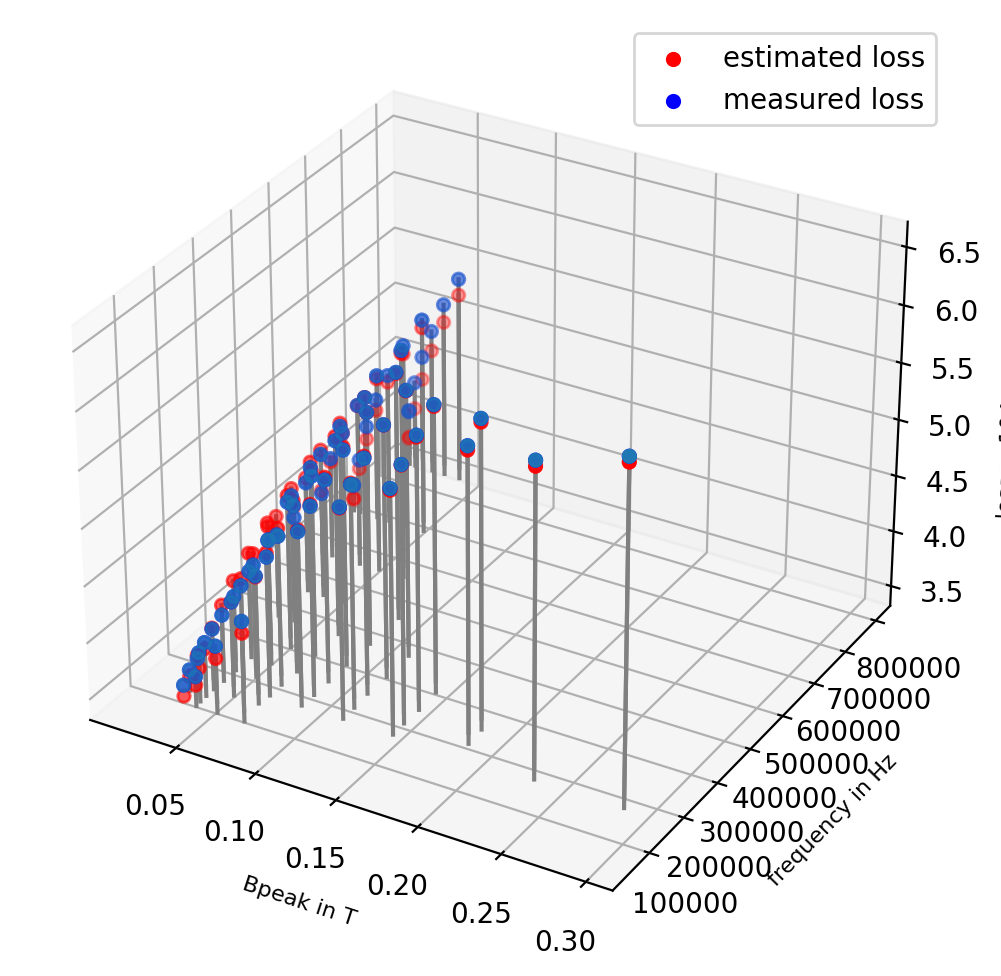

In [ ]:
p_estimated = estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine)
true_loss = ploss_sine
b_ax = b_max_sine
f_ax = freq_sine

loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = True)

0.17248815703264392


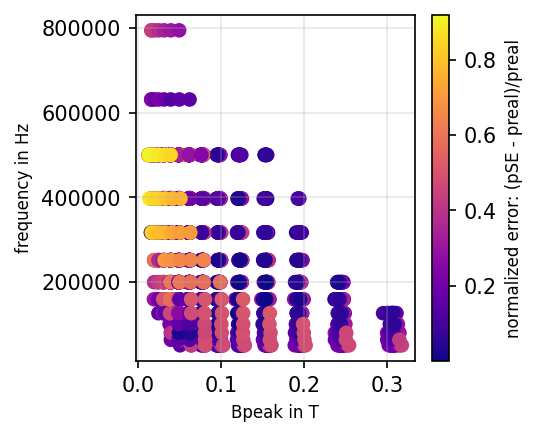

In [ ]:
# in sample error (training set = test set)
wp_error_norm = (estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_max) - wp_ploss) / wp_ploss

print(normalized_error(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_max, wp_ploss))


# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)

# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = matplotlib.colormaps['plasma']
xy = range(20)
sc = plt.scatter(wp_b_max, wp_freq, c=abs(wp_error_norm), vmin=None, vmax=None, s=None, cmap=cm)
cbar = plt.colorbar(sc, )
cbar.set_label('normalized error: (pSE - preal)/preal', fontsize=fontsize)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)

plt.show()

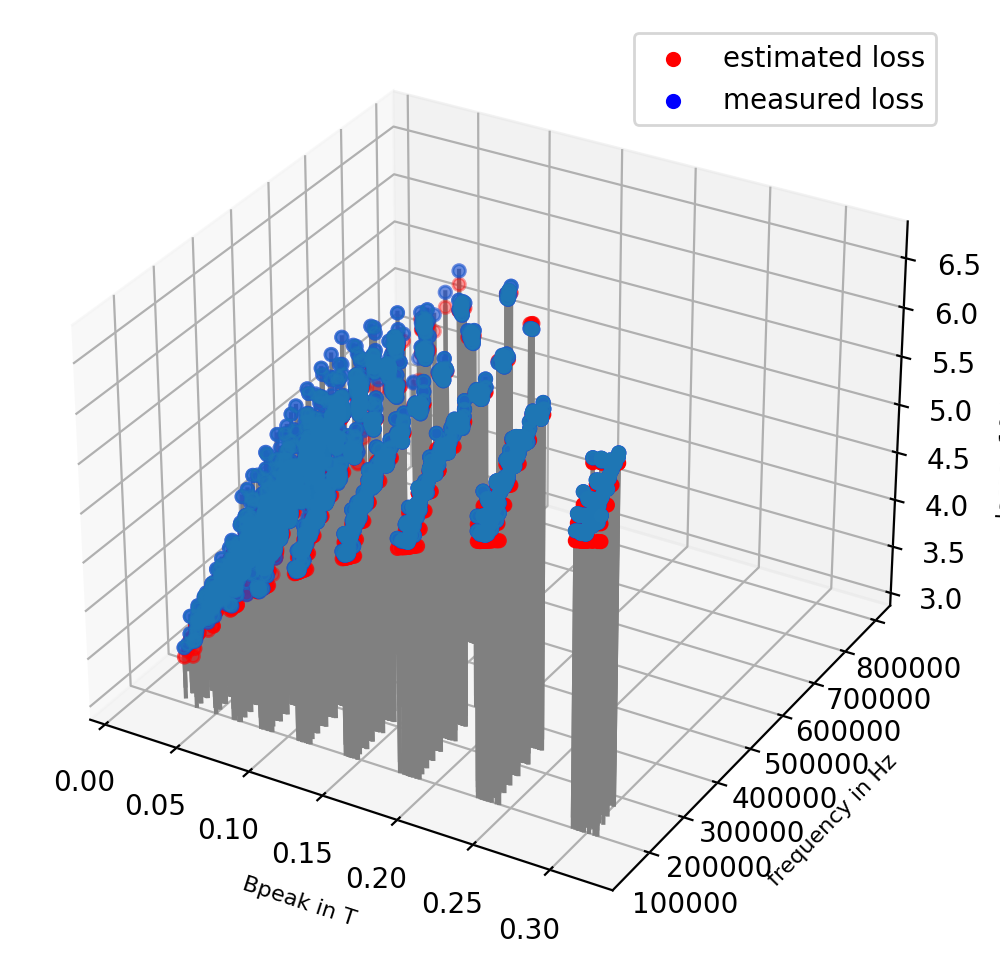

In [ ]:
p_estimated = estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_max)
true_loss = wp_ploss
b_ax = wp_b_max
f_ax = wp_freq

loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = True)

In [ ]:
def iGSE2(alpha, beta, k, b_vec, f, samples):
    theta = np.linspace(0, 2*np.pi, 20)
    k_i = k / ((2*np.pi)**(alpha-1) * np.trapz(abs(np.cos(theta))**alpha * 2**(beta-alpha)))
    print(b_vec.shape)
    print(b_vec.shape)
    dB_dt = np.gradient(b_vec, 1/f/samples, axis=1)
    print(dB_dt)
    # print(f.shape)

    # k_i = k
    # dB_dt = np.gradient(b_vec, 1)
    # print(dB_dt[0].shape)
    # print(np.abs(dB_dt[0]).shape)
    # print((np.max(b, axis=1)-np.min(b, axis=1)).shape)
    integrant = k_i * np.matmul(np.abs(dB_dt[0]).T**alpha, ((np.max(b_vec, axis=1)-np.min(b_vec, axis=1))**(beta-alpha)))
    return f * np.trapz(integrant)

def iGSE(alpha, beta, k, b_vec, fs, samples):
    theta = np.linspace(0, 2*np.pi, 100)
    k_i = k / ((2*np.pi)**(alpha-1) * np.trapz(abs(np.cos(theta))**alpha * 2**(beta-alpha), dx=2*np.pi/100))
    
    loss = []
    for i, f_i in enumerate(fs):
        dt = 1/f_i/samples
        b_i = b_vec[i]
        # print(b_i.shape)
        dB_dt = np.gradient(b_i, dt, axis=0)
        # print(dB_dt.shape)    
        integrant = k_i * np.abs(dB_dt)**alpha * (np.max(b_i, axis=0)-np.min(b_i, axis=0))**(beta-alpha)
        
        loss.append(f_i * np.trapz(integrant, axis=0, dx=dt))

    return loss

def estimated_loss_iGSE(alpha, beta, k, f_vec, b_vec_vec, samples):
    return iGSE(alpha, beta, k, b_vec_vec, f_vec, samples)

def normalized_error_iGSE(alpha, beta, k, f_vec, b_vec_vec, p_loss_reference, samples):
    return np.mean(abs((estimated_loss_iGSE(alpha, beta, k, f_vec, b_vec_vec, samples) - p_loss_reference) / p_loss_reference))

0.14923109200525914


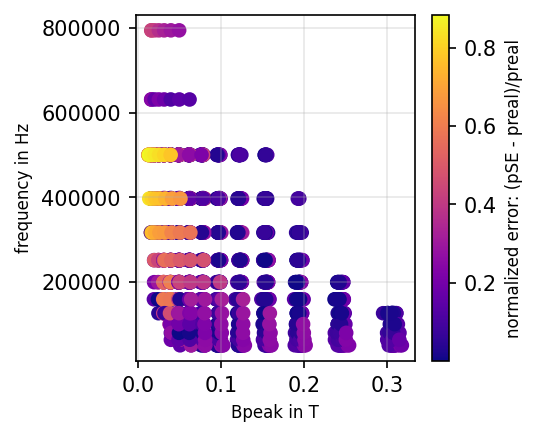

In [ ]:
# in sample error (training set = test set)
error_norm = (estimated_loss_iGSE(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_vecs, no_samples) - wp_ploss) / wp_ploss

print(normalized_error_iGSE(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_vecs, wp_ploss, no_samples))

# 1D error plots
#plt.scatter(b_max, error_norm)
#plt.scatter(freq, error_norm)

# 2D error plots
plt.figure(dpi=150, figsize=(3,3))
cm = matplotlib.colormaps['plasma']
xy = range(20)
sc = plt.scatter(wp_b_max, wp_freq, c=np.abs(error_norm), vmin=None, vmax=None, s=None, cmap=cm)
cbar = plt.colorbar(sc, )
cbar.set_label('normalized error: (pSE - preal)/preal', fontsize=fontsize)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)

plt.show()

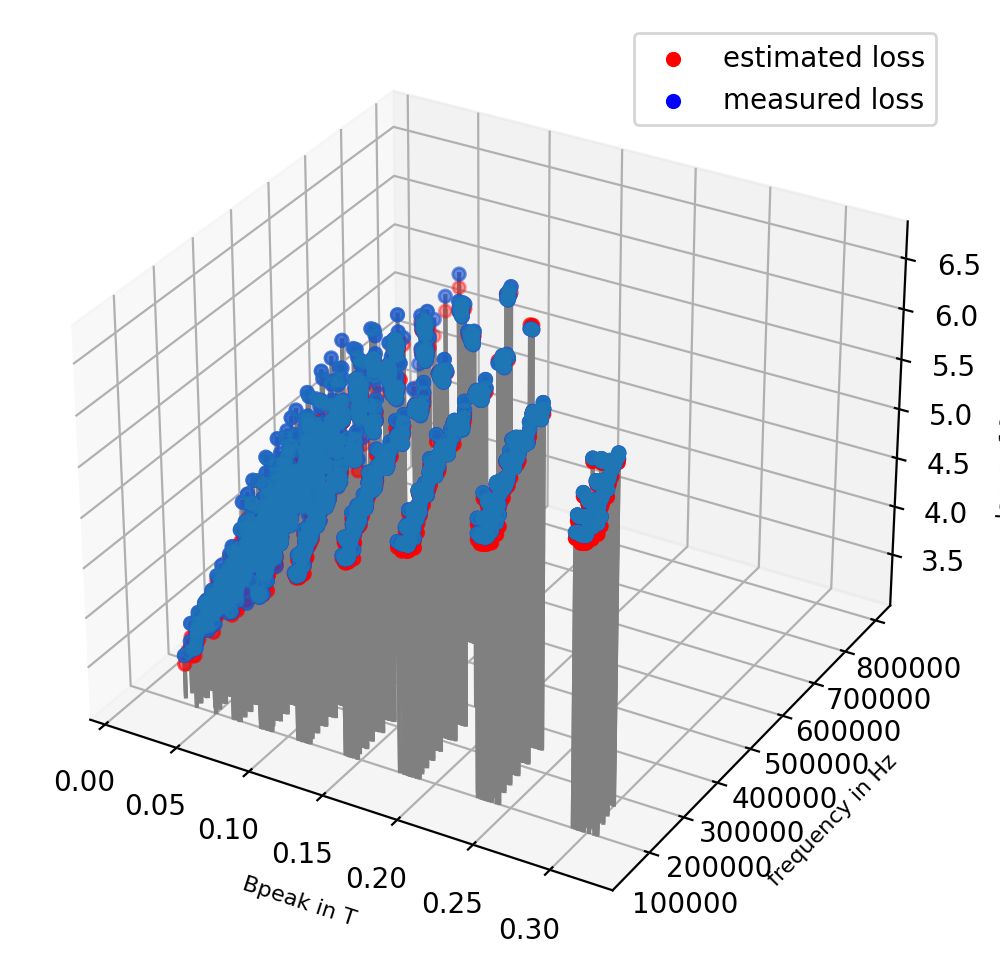

In [ ]:
p_estimated = estimated_loss_iGSE(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], wp_freq, wp_b_vecs, no_samples)
true_loss = wp_ploss
b_ax = wp_b_max
f_ax = wp_freq


loss_over_b_and_f_3D(f_ax, b_ax, true_loss, p_estimated, log_plot = True)
